In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns

#import pydicom
import time
import gc
import operator 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
from skimage.io import imread,imshow
from helper import *
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 8153
#device=device_by_name("Tesla")
device=device_by_name("RTX")
#device=device_by_name("1060")
torch.cuda.set_device(device)
#device = "cpu"
sendmeemail=Email_Progress(my_gmail,my_pass,to_email,'Densenet161-Copy2-2 results')

In [3]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [4]:
def get_submission_ids(image_ids,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [5]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df.shape
train_df=train_df[~train_df.PatientID.isin(bad_images)].reset_index(drop=True)
train_df=train_df.drop_duplicates().reset_index(drop=True)
train_df.shape
train_df.head()

(674510, 15)

(674252, 15)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [6]:
test_df = pd.read_csv(data_dir+'test.csv')
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [7]:
split_sid = train_df.PID.unique()
splits=list(KFold(n_splits=3,shuffle=True, random_state=SEED).split(split_sid))


In [8]:
def my_loss(y_pred,y_true,weights):
    window=(y_true>=0).to(torch.float)
    loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*weights.expand_as(y_true)).mean()
    return loss

In [9]:
class Metric():
    def __init__(self,weights,k=0.03):
        self.weights=weights
        self.k=k
        self.zero()
        
    def zero(self):
        self.loss_sum=0.
        self.loss_count=0.
        self.lossf=0.
        
    def calc(self,y_pred,y_true,prefix=""):
        window=(y_true>=0).to(torch.float)
        loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*self.weights.expand_as(y_true)).mean()/(window.mean()+1e-5)
        self.lossf=self.lossf*(1-self.k)+loss*self.k
        self.loss_sum=self.loss_sum+loss*window.sum()
        self.loss_count=self.loss_count+window.sum()
        return({prefix+'mloss':self.lossf})    
        
    def calc_sums(self,prefix=""):
        return({prefix+'mloss_tot':self.loss_sum/self.loss_count})    



In [10]:
#features=(features-features.mean())/features.std()

In [11]:
class SimpleModel(nn.Module):
    def __init__(self,in_size):
        super(SimpleModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (7,in_size), padding=(3,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 5, padding=2)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 3, padding=1)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(64, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [12]:
class SimpleModel2(nn.Module):
    def __init__(self,in_size):
        super(SimpleModel2, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(64, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [13]:
class ClassModel(nn.Module):
    def __init__(self,in_size):
        super(ClassModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(128, 6, 3, padding=1)
        
        self.conv2d1class=torch.nn.Conv2d(1, 128, (9,in_size), padding=(4,0))
        self.bn0class=torch.nn.BatchNorm1d(128)
        self.maxpool1class=torch.nn.MaxPool1d(3)
        self.conv1d1class=torch.nn.Conv1d(128, 128, 3, padding=1)
        self.bn1class=torch.nn.BatchNorm1d(128)
        self.maxpool2class=torch.nn.MaxPool1d(3)
        self.conv1d2class=torch.nn.Conv1d(128, 64, 2, padding=1)
        self.bn2class=torch.nn.BatchNorm1d(64)

        
        
    def forward(self, x):
        z=x
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        z=self.conv2d1class(z.unsqueeze(1)).squeeze(-1)
        z=self.bn0class(z)
        z=self.maxpool1class(z)
        z=self.conv1d1class(z)
        z=self.maxpool2class(z)
        z=self.conv1d2class(z)
        z=self.bn2class(z)
        z=F.max_pool1d(z,kernel_size=z.shape[-1])
        z=z.expand_as(x)
        x=torch.cat([x,z],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [14]:
class ResModel(nn.Module):
    def __init__(self,in_size):
        super(ResModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(64)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x0 = self.relu0(x)
        x = self.conv1d1(x0)
        x = self.bn1(x)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [15]:
class ResDropModel(nn.Module):
    def __init__(self,in_size,dropout=0.2):
        super(ResDropModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(64)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)
        self.dropout=dropout
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = F.dropout(x,self.dropout)
        x0 = self.relu0(x) 
        x = self.conv1d1(x0)
#        x = self.bn1(x)
        x = F.dropout(x,self.dropout)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
#        x = self.bn2(x)
        x = F.dropout(x,self.dropout)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        x = F.dropout(x,self.dropout)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [21]:

class ResModelIn(nn.Module):
    def __init__(self,in_size):
        super(ResModelIn, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(64)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 3, padding=1)
        self.bn1=torch.nn.BatchNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 3, padding=1)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)

        
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv2d1(x).squeeze(-1)
        x = self.bn0(x)
        x0 = self.relu0(x)
        x = self.conv1d1(x0)
        x = self.bn1(x)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        x = self.conv1d3(x)
        out = x.transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [17]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (5,2208), padding=(2,0))
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 6, 1)

        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.relu0(x)
        out = self.conv1d1(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


torch.Size([2697008, 552])

torch.Size([674252, 4, 552])

<IPython.core.display.Javascript object>


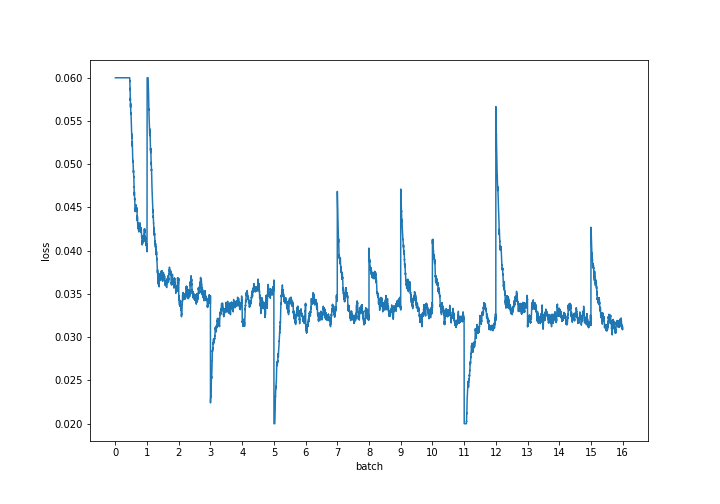

{'loss': 0.04167706402258471, 'mloss': tensor(0.0742), 'val_loss': 0.05590808883268074, 'val_mloss_tot': tensor(0.0971)}


{'loss': 0.036256391311289195, 'mloss': tensor(0.0631), 'val_loss': 0.043848537436223085, 'val_mloss_tot': tensor(0.0761)}


{'loss': 0.03480906351941554, 'mloss': tensor(0.0624), 'val_loss': 0.04348259478958846, 'val_mloss_tot': tensor(0.0755)}


{'loss': 0.03371652065768481, 'mloss': tensor(0.0579), 'val_loss': 0.046524087373130574, 'val_mloss_tot': tensor(0.0808)}


{'loss': 0.03661780575075163, 'mloss': tensor(0.0681), 'val_loss': 0.04373670440153425, 'val_mloss_tot': tensor(0.0759)}


{'loss': 0.033936010950701576, 'mloss': tensor(0.0643), 'val_loss': 0.04348231445690571, 'val_mloss_tot': tensor(0.0755)}


{'loss': 0.035261638974505294, 'mloss': tensor(0.0661), 'val_loss': 0.04288420084464763, 'val_mloss_tot': tensor(0.0745)}


{'loss': 0.032110283646654574, 'mloss': tensor(0.0548), 'val_loss': 0.0428769022600239, 'val_mloss_tot': tensor(0.0744)}


{'loss': 0.033144072714455124, 'mloss': tensor(0.0547), 'val_loss': 0.044331535924079235, 'val_mloss_tot': tensor(0.0770)}


{'loss': 0.03339732859745005, 'mloss': tensor(0.0588), 'val_loss': 0.04270774712946651, 'val_mloss_tot': tensor(0.0741)}


{'loss': 0.03158736167138343, 'mloss': tensor(0.0530), 'val_loss': 0.04287465912716582, 'val_mloss_tot': tensor(0.0744)}


{'loss': 0.031929068904715814, 'mloss': tensor(0.0557), 'val_loss': 0.042910007584445506, 'val_mloss_tot': tensor(0.0745)}


{'loss': 0.03409919834492402, 'mloss': tensor(0.0603), 'val_loss': 0.045566824903674974, 'val_mloss_tot': tensor(0.0791)}


{'loss': 0.03245112796302723, 'mloss': tensor(0.0552), 'val_loss': 0.04351676362417547, 'val_mloss_tot': tensor(0.0756)}


{'loss': 0.03135519440078807, 'mloss': tensor(0.0535), 'val_loss': 0.04255671212289097, 'val_mloss_tot': tensor(0.0739)}


{'loss': 0.03116147908961984, 'mloss': tensor(0.0532), 'val_loss': 0.0428219933666087, 'val_mloss_tot': tensor(0.0743)}




(0.04237929877958128, {'val_loss': 0.04237929877958128, 'val_mloss_tot': tensor(0.0736)})


In [22]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet161_3' , 'classifier_splits',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModelIn(features.shape[-1])
version=version+'_fullhead_resmodelin'
_=model.to(device)

loss_func=my_loss
#fig,ax = plt.subplots(figsize=(10,7))
#gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [23]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet161_3' , 'classifier_splits',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModelIn(features.shape[-1])
version=version+'_fullhead_resmodelin'
_=model.to(device)

loss_func=my_loss
#fig,ax = plt.subplots(figsize=(10,7))
#gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 552])

torch.Size([674252, 4, 552])

{'loss': 0.0387265727219696, 'mloss': tensor(0.0678), 'val_loss': 0.044838193961896186, 'val_mloss_tot': tensor(0.0783)}


{'loss': 0.034466003122766, 'mloss': tensor(0.0585), 'val_loss': 0.0430770354674811, 'val_mloss_tot': tensor(0.0752)}


{'loss': 0.03434242195058409, 'mloss': tensor(0.0563), 'val_loss': 0.04258446187326094, 'val_mloss_tot': tensor(0.0743)}


{'loss': 0.033181906740464416, 'mloss': tensor(0.0568), 'val_loss': 0.04246339086534046, 'val_mloss_tot': tensor(0.0741)}


{'loss': 0.03494524290186681, 'mloss': tensor(0.0606), 'val_loss': 0.04330588759649999, 'val_mloss_tot': tensor(0.0756)}


{'loss': 0.032521048857145636, 'mloss': tensor(0.0527), 'val_loss': 0.04381274448639554, 'val_mloss_tot': tensor(0.0765)}


{'loss': 0.03287978087883796, 'mloss': tensor(0.0572), 'val_loss': 0.04250730006024241, 'val_mloss_tot': tensor(0.0742)}


{'loss': 0.032985312013320806, 'mloss': tensor(0.0567), 'val_loss': 0.042289436982217724, 'val_mloss_tot': tensor(0.0738)}


{'loss': 0.033667893145663805, 'mloss': tensor(0.0578), 'val_loss': 0.04240204673601178, 'val_mloss_tot': tensor(0.0740)}


{'loss': 0.03210040122757251, 'mloss': tensor(0.0546), 'val_loss': 0.043695122689553875, 'val_mloss_tot': tensor(0.0763)}


{'loss': 0.03323020796512741, 'mloss': tensor(0.0582), 'val_loss': 0.042599714002231275, 'val_mloss_tot': tensor(0.0744)}


{'loss': 0.03205078641404307, 'mloss': tensor(0.0536), 'val_loss': 0.04233182380543794, 'val_mloss_tot': tensor(0.0739)}


{'loss': 0.03454181979603452, 'mloss': tensor(0.0628), 'val_loss': 0.043219027450171914, 'val_mloss_tot': tensor(0.0754)}


{'loss': 0.032781654362266745, 'mloss': tensor(0.0560), 'val_loss': 0.0427882642411377, 'val_mloss_tot': tensor(0.0747)}


{'loss': 0.03212186620043692, 'mloss': tensor(0.0548), 'val_loss': 0.04182602144300756, 'val_mloss_tot': tensor(0.0730)}


{'loss': 0.030734876378474576, 'mloss': tensor(0.0509), 'val_loss': 0.0422608604313942, 'val_mloss_tot': tensor(0.0738)}




0.04182602144300756


In [24]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet161_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModelIn(features.shape[-1])
version=version+'_fullhead_resmodelin'
_=model.to(device)

loss_func=my_loss
#fig,ax = plt.subplots(figsize=(10,7))
#gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 552])

torch.Size([674252, 4, 552])

{'loss': 0.04073539882877707, 'mloss': tensor(0.0717), 'val_loss': 0.04281019055390079, 'val_mloss_tot': tensor(0.0742)}


{'loss': 0.03406582058648925, 'mloss': tensor(0.0598), 'val_loss': 0.041701706447478, 'val_mloss_tot': tensor(0.0723)}


{'loss': 0.03490280856452313, 'mloss': tensor(0.0583), 'val_loss': 0.0411136549670396, 'val_mloss_tot': tensor(0.0713)}


{'loss': 0.032886987446781035, 'mloss': tensor(0.0573), 'val_loss': 0.04107625645773458, 'val_mloss_tot': tensor(0.0712)}


{'loss': 0.03389548136728074, 'mloss': tensor(0.0578), 'val_loss': 0.04162528278452936, 'val_mloss_tot': tensor(0.0722)}


{'loss': 0.033918124941244195, 'mloss': tensor(0.0579), 'val_loss': 0.04175184694293134, 'val_mloss_tot': tensor(0.0724)}


{'loss': 0.03388255233204087, 'mloss': tensor(0.0583), 'val_loss': 0.041060569869317665, 'val_mloss_tot': tensor(0.0712)}


{'loss': 0.03253072022737952, 'mloss': tensor(0.0565), 'val_loss': 0.041044457847702095, 'val_mloss_tot': tensor(0.0712)}


{'loss': 0.03309435873029265, 'mloss': tensor(0.0582), 'val_loss': 0.040895693461763964, 'val_mloss_tot': tensor(0.0709)}


{'loss': 0.03482424947104899, 'mloss': tensor(0.0612), 'val_loss': 0.04160044846019428, 'val_mloss_tot': tensor(0.0721)}


{'loss': 0.03244430588824685, 'mloss': tensor(0.0568), 'val_loss': 0.040756313820722805, 'val_mloss_tot': tensor(0.0707)}


{'loss': 0.034333043081841534, 'mloss': tensor(0.0632), 'val_loss': 0.040878147942018626, 'val_mloss_tot': tensor(0.0709)}


{'loss': 0.03303467254795116, 'mloss': tensor(0.0574), 'val_loss': 0.04168235944822577, 'val_mloss_tot': tensor(0.0723)}


{'loss': 0.03300164717549735, 'mloss': tensor(0.0587), 'val_loss': 0.040926441561724314, 'val_mloss_tot': tensor(0.0710)}


{'loss': 0.03186864834671021, 'mloss': tensor(0.0556), 'val_loss': 0.0412252998332782, 'val_mloss_tot': tensor(0.0715)}


{'loss': 0.032076405272649475, 'mloss': tensor(0.0568), 'val_loss': 0.04079597407098621, 'val_mloss_tot': tensor(0.0707)}




0.040756313820722805


In [25]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModelIn(features.shape[-1])
version=version+'_fullhead_resmodelin'
_=model.to(device)

loss_func=my_loss
#fig,ax = plt.subplots(figsize=(10,7))
#gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

{'loss': 0.037539493131038285, 'mloss': tensor(0.0640), 'val_loss': 0.045838898307015305, 'val_mloss_tot': tensor(0.0796)}


{'loss': 0.03600192408071844, 'mloss': tensor(0.0654), 'val_loss': 0.0433007774064822, 'val_mloss_tot': tensor(0.0752)}


{'loss': 0.033823077865254, 'mloss': tensor(0.0566), 'val_loss': 0.04329341885592476, 'val_mloss_tot': tensor(0.0752)}


{'loss': 0.03326308322811354, 'mloss': tensor(0.0558), 'val_loss': 0.04344624691135869, 'val_mloss_tot': tensor(0.0754)}


{'loss': 0.03258287574550202, 'mloss': tensor(0.0523), 'val_loss': 0.04403883105962826, 'val_mloss_tot': tensor(0.0765)}


{'loss': 0.03376653673532168, 'mloss': tensor(0.0566), 'val_loss': 0.04423192330278236, 'val_mloss_tot': tensor(0.0768)}


{'loss': 0.0319929820247773, 'mloss': tensor(0.0527), 'val_loss': 0.042960380384092924, 'val_mloss_tot': tensor(0.0746)}


{'loss': 0.03319707640883184, 'mloss': tensor(0.0554), 'val_loss': 0.04313173177514427, 'val_mloss_tot': tensor(0.0749)}


{'loss': 0.03378131093102307, 'mloss': tensor(0.0600), 'val_loss': 0.04426626028009034, 'val_mloss_tot': tensor(0.0769)}


{'loss': 0.0339850716046941, 'mloss': tensor(0.0601), 'val_loss': 0.04323946534004521, 'val_mloss_tot': tensor(0.0751)}


{'loss': 0.03197806483560676, 'mloss': tensor(0.0517), 'val_loss': 0.04327446104972417, 'val_mloss_tot': tensor(0.0751)}


{'loss': 0.032023074212498115, 'mloss': tensor(0.0542), 'val_loss': 0.043165114571184396, 'val_mloss_tot': tensor(0.0749)}


{'loss': 0.03439757852202632, 'mloss': tensor(0.0615), 'val_loss': 0.043784952961055223, 'val_mloss_tot': tensor(0.0760)}


{'loss': 0.03271123613727149, 'mloss': tensor(0.0561), 'val_loss': 0.04395230886414005, 'val_mloss_tot': tensor(0.0763)}


{'loss': 0.03216968509987529, 'mloss': tensor(0.0555), 'val_loss': 0.0431863771908655, 'val_mloss_tot': tensor(0.0750)}


{'loss': 0.033486763714719266, 'mloss': tensor(0.0612), 'val_loss': 0.04332060701950118, 'val_mloss_tot': tensor(0.0752)}




0.042960380384092924


In [26]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModelIn(features.shape[-1])
version=version+'_fullhead_resmodelin'
_=model.to(device)

loss_func=my_loss
#fig,ax = plt.subplots(figsize=(10,7))
#gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

{'loss': 0.03849257902821731, 'mloss': tensor(0.0654), 'val_loss': 0.043494956268043054, 'val_mloss_tot': tensor(0.0759)}


{'loss': 0.03415831878646108, 'mloss': tensor(0.0580), 'val_loss': 0.04287243678189087, 'val_mloss_tot': tensor(0.0748)}


{'loss': 0.0355496313077802, 'mloss': tensor(0.0652), 'val_loss': 0.04211631037703738, 'val_mloss_tot': tensor(0.0735)}


{'loss': 0.03429856706574426, 'mloss': tensor(0.0604), 'val_loss': 0.04243326060496634, 'val_mloss_tot': tensor(0.0741)}


{'loss': 0.036112788853069636, 'mloss': tensor(0.0657), 'val_loss': 0.042650102609314205, 'val_mloss_tot': tensor(0.0744)}


{'loss': 0.03446846913167554, 'mloss': tensor(0.0575), 'val_loss': 0.0431575855819463, 'val_mloss_tot': tensor(0.0753)}


{'loss': 0.03334594779703006, 'mloss': tensor(0.0556), 'val_loss': 0.042385484539426685, 'val_mloss_tot': tensor(0.0740)}


{'loss': 0.03252855210880968, 'mloss': tensor(0.0558), 'val_loss': 0.042083544732730196, 'val_mloss_tot': tensor(0.0735)}


{'loss': 0.03400772250513949, 'mloss': tensor(0.0593), 'val_loss': 0.04335703963595556, 'val_mloss_tot': tensor(0.0757)}


{'loss': 0.03313569605610544, 'mloss': tensor(0.0542), 'val_loss': 0.04235471432642421, 'val_mloss_tot': tensor(0.0739)}


{'loss': 0.03244256377754201, 'mloss': tensor(0.0537), 'val_loss': 0.0422337812621419, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.03316348099965779, 'mloss': tensor(0.0602), 'val_loss': 0.0423759501734067, 'val_mloss_tot': tensor(0.0740)}


{'loss': 0.03382189209107739, 'mloss': tensor(0.0580), 'val_loss': 0.0427149345257842, 'val_mloss_tot': tensor(0.0746)}


{'loss': 0.03347832594908626, 'mloss': tensor(0.0576), 'val_loss': 0.042302389729132014, 'val_mloss_tot': tensor(0.0738)}


{'loss': 0.03359656280229718, 'mloss': tensor(0.0579), 'val_loss': 0.04215017299326818, 'val_mloss_tot': tensor(0.0736)}


{'loss': 0.034744892641138274, 'mloss': tensor(0.0634), 'val_loss': 0.04239256744750026, 'val_mloss_tot': tensor(0.0740)}




0.042083544732730196


In [27]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModelIn(features.shape[-1])
version=version+'_fullhead_resmodelin'
_=model.to(device)

loss_func=my_loss
#fig,ax = plt.subplots(figsize=(10,7))
#gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

{'loss': 0.04012623265427795, 'mloss': tensor(0.0707), 'val_loss': 0.04320993522879452, 'val_mloss_tot': tensor(0.0749)}


{'loss': 0.03613981602455292, 'mloss': tensor(0.0652), 'val_loss': 0.04216829231903507, 'val_mloss_tot': tensor(0.0731)}


{'loss': 0.03537313725671305, 'mloss': tensor(0.0601), 'val_loss': 0.04156312505310869, 'val_mloss_tot': tensor(0.0721)}


{'loss': 0.033966707746071044, 'mloss': tensor(0.0581), 'val_loss': 0.04128027338594235, 'val_mloss_tot': tensor(0.0716)}


{'loss': 0.037536217508421274, 'mloss': tensor(0.0661), 'val_loss': 0.043027594192366445, 'val_mloss_tot': tensor(0.0746)}


{'loss': 0.03457227327925857, 'mloss': tensor(0.0591), 'val_loss': 0.04279562010168295, 'val_mloss_tot': tensor(0.0742)}


{'loss': 0.033718726464694655, 'mloss': tensor(0.0552), 'val_loss': 0.04153316746135541, 'val_mloss_tot': tensor(0.0720)}


{'loss': 0.03434841516792772, 'mloss': tensor(0.0609), 'val_loss': 0.04113389785961234, 'val_mloss_tot': tensor(0.0713)}


{'loss': 0.0344257942932218, 'mloss': tensor(0.0585), 'val_loss': 0.04217123835613685, 'val_mloss_tot': tensor(0.0731)}


{'loss': 0.034373567662240756, 'mloss': tensor(0.0610), 'val_loss': 0.041285459026740176, 'val_mloss_tot': tensor(0.0716)}


{'loss': 0.03319522920385918, 'mloss': tensor(0.0568), 'val_loss': 0.041145565592697615, 'val_mloss_tot': tensor(0.0713)}


{'loss': 0.03269792939032811, 'mloss': tensor(0.0554), 'val_loss': 0.041036104825852904, 'val_mloss_tot': tensor(0.0711)}


{'loss': 0.033396672099071746, 'mloss': tensor(0.0563), 'val_loss': 0.041227284656020956, 'val_mloss_tot': tensor(0.0715)}


{'loss': 0.0342792690253823, 'mloss': tensor(0.0596), 'val_loss': 0.04139529411873684, 'val_mloss_tot': tensor(0.0718)}


{'loss': 0.033230531793840445, 'mloss': tensor(0.0585), 'val_loss': 0.040954256682597064, 'val_mloss_tot': tensor(0.0710)}


{'loss': 0.03333873331711547, 'mloss': tensor(0.0574), 'val_loss': 0.04095312928909372, 'val_mloss_tot': tensor(0.0710)}




(0.040845940620156715, {'val_loss': 0.040845940620156715, 'val_mloss_tot': tensor(0.0708)})


In [28]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet201_3' , 'classifier_splits',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModelIn(features.shape[-1])
version=version+'_fullhead_resmodelin'
_=model.to(device)

loss_func=my_loss
#fig,ax = plt.subplots(figsize=(10,7))
#gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 240])

torch.Size([674252, 4, 240])

{'loss': 0.039764723982040194, 'mloss': tensor(0.0714), 'val_loss': 0.044894292772853096, 'val_mloss_tot': tensor(0.0779)}


{'loss': 0.03835775130204654, 'mloss': tensor(0.0719), 'val_loss': 0.04427089181549737, 'val_mloss_tot': tensor(0.0769)}


{'loss': 0.035141041337971225, 'mloss': tensor(0.0610), 'val_loss': 0.04320066419815452, 'val_mloss_tot': tensor(0.0750)}


{'loss': 0.034359307082842384, 'mloss': tensor(0.0582), 'val_loss': 0.04312964030449724, 'val_mloss_tot': tensor(0.0749)}


{'loss': 0.03685427219358404, 'mloss': tensor(0.0680), 'val_loss': 0.044405551732797637, 'val_mloss_tot': tensor(0.0771)}


{'loss': 0.03479677390615877, 'mloss': tensor(0.0616), 'val_loss': 0.04348299072211232, 'val_mloss_tot': tensor(0.0755)}


{'loss': 0.03607972521946341, 'mloss': tensor(0.0659), 'val_loss': 0.04292204492642852, 'val_mloss_tot': tensor(0.0745)}


{'loss': 0.034288864056904345, 'mloss': tensor(0.0622), 'val_loss': 0.04289080399395944, 'val_mloss_tot': tensor(0.0745)}


{'loss': 0.03557981483371707, 'mloss': tensor(0.0611), 'val_loss': 0.04327118190078826, 'val_mloss_tot': tensor(0.0751)}


{'loss': 0.03464851290774139, 'mloss': tensor(0.0595), 'val_loss': 0.04287544033017578, 'val_mloss_tot': tensor(0.0744)}


{'loss': 0.03442252916010414, 'mloss': tensor(0.0624), 'val_loss': 0.04323059978913241, 'val_mloss_tot': tensor(0.0751)}


{'loss': 0.03224836766600221, 'mloss': tensor(0.0563), 'val_loss': 0.04268991309241048, 'val_mloss_tot': tensor(0.0741)}


{'loss': 0.03494698344984765, 'mloss': tensor(0.0623), 'val_loss': 0.04332712383280173, 'val_mloss_tot': tensor(0.0752)}


{'loss': 0.03322310206591019, 'mloss': tensor(0.0561), 'val_loss': 0.0428789083001759, 'val_mloss_tot': tensor(0.0744)}


{'loss': 0.03332472471453514, 'mloss': tensor(0.0570), 'val_loss': 0.04285133275285987, 'val_mloss_tot': tensor(0.0744)}


{'loss': 0.03273017802128206, 'mloss': tensor(0.0574), 'val_loss': 0.042764421422814426, 'val_mloss_tot': tensor(0.0742)}




0.04268991309241048


In [29]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet201_3' , 'classifier_splits',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModelIn(features.shape[-1])
version=version+'_fullhead_resmodelin'
_=model.to(device)

loss_func=my_loss
#fig,ax = plt.subplots(figsize=(10,7))
#gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 240])

torch.Size([674252, 4, 240])

{'loss': 0.039442787547604996, 'mloss': tensor(0.0712), 'val_loss': 0.04309742703761269, 'val_mloss_tot': tensor(0.0752)}


{'loss': 0.03570648855671449, 'mloss': tensor(0.0636), 'val_loss': 0.04365104069683428, 'val_mloss_tot': tensor(0.0762)}


{'loss': 0.03457874173117134, 'mloss': tensor(0.0606), 'val_loss': 0.04234834254106007, 'val_mloss_tot': tensor(0.0739)}


{'loss': 0.03429821977844839, 'mloss': tensor(0.0632), 'val_loss': 0.04253766033912032, 'val_mloss_tot': tensor(0.0742)}


{'loss': 0.03553914649557721, 'mloss': tensor(0.0625), 'val_loss': 0.04312436075812978, 'val_mloss_tot': tensor(0.0753)}


{'loss': 0.03338398876652952, 'mloss': tensor(0.0544), 'val_loss': 0.04293780306740323, 'val_mloss_tot': tensor(0.0749)}


{'loss': 0.033893801807394805, 'mloss': tensor(0.0597), 'val_loss': 0.042302889682397975, 'val_mloss_tot': tensor(0.0738)}


{'loss': 0.03380017258293661, 'mloss': tensor(0.0599), 'val_loss': 0.04230497664453962, 'val_mloss_tot': tensor(0.0738)}


{'loss': 0.03353890177189612, 'mloss': tensor(0.0561), 'val_loss': 0.044276647394659314, 'val_mloss_tot': tensor(0.0773)}


{'loss': 0.03321063922953563, 'mloss': tensor(0.0553), 'val_loss': 0.04256088630546157, 'val_mloss_tot': tensor(0.0743)}


{'loss': 0.033768575453433626, 'mloss': tensor(0.0545), 'val_loss': 0.042077437350980754, 'val_mloss_tot': tensor(0.0734)}


{'loss': 0.03368124768523619, 'mloss': tensor(0.0594), 'val_loss': 0.04211264846551164, 'val_mloss_tot': tensor(0.0735)}


{'loss': 0.03567064783609676, 'mloss': tensor(0.0626), 'val_loss': 0.042724035232804894, 'val_mloss_tot': tensor(0.0746)}


{'loss': 0.033155001264561425, 'mloss': tensor(0.0550), 'val_loss': 0.042187325439484016, 'val_mloss_tot': tensor(0.0736)}


{'loss': 0.032244878915403764, 'mloss': tensor(0.0559), 'val_loss': 0.04243998259260524, 'val_mloss_tot': tensor(0.0741)}


{'loss': 0.0311923550840585, 'mloss': tensor(0.0516), 'val_loss': 0.04222416143818963, 'val_mloss_tot': tensor(0.0737)}




(0.041985440994726446, {'val_loss': 0.041985440994726446, 'val_mloss_tot': tensor(0.0733)})


In [30]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet201_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModelIn(features.shape[-1])
version=version+'_fullhead_resmodelin'
_=model.to(device)

loss_func=my_loss
#fig,ax = plt.subplots(figsize=(10,7))
#gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 240])

torch.Size([674252, 4, 240])

{'loss': 0.03750202917414093, 'mloss': tensor(0.0667), 'val_loss': 0.042417800090656495, 'val_mloss_tot': tensor(0.0735)}


{'loss': 0.03675899816758786, 'mloss': tensor(0.0651), 'val_loss': 0.04181985430456148, 'val_mloss_tot': tensor(0.0725)}


{'loss': 0.033895101288791814, 'mloss': tensor(0.0579), 'val_loss': 0.04150738292993069, 'val_mloss_tot': tensor(0.0720)}


{'loss': 0.03387878537351306, 'mloss': tensor(0.0561), 'val_loss': 0.04135231425173654, 'val_mloss_tot': tensor(0.0717)}


{'loss': 0.03463798510512306, 'mloss': tensor(0.0572), 'val_loss': 0.042111083948892986, 'val_mloss_tot': tensor(0.0730)}


{'loss': 0.03502527276408124, 'mloss': tensor(0.0601), 'val_loss': 0.041856269732925104, 'val_mloss_tot': tensor(0.0726)}


{'loss': 0.03334939728186067, 'mloss': tensor(0.0566), 'val_loss': 0.041405701556752245, 'val_mloss_tot': tensor(0.0718)}


{'loss': 0.03446678333583154, 'mloss': tensor(0.0611), 'val_loss': 0.0411008474637245, 'val_mloss_tot': tensor(0.0713)}


{'loss': 0.03446215759257943, 'mloss': tensor(0.0615), 'val_loss': 0.041479332504445326, 'val_mloss_tot': tensor(0.0719)}


{'loss': 0.03339673546783279, 'mloss': tensor(0.0559), 'val_loss': 0.041708311622301715, 'val_mloss_tot': tensor(0.0723)}


{'loss': 0.03450384137803052, 'mloss': tensor(0.0605), 'val_loss': 0.0411337310221193, 'val_mloss_tot': tensor(0.0713)}


{'loss': 0.03337072220356077, 'mloss': tensor(0.0583), 'val_loss': 0.041190464828356074, 'val_mloss_tot': tensor(0.0714)}


{'loss': 0.03285504964241579, 'mloss': tensor(0.0550), 'val_loss': 0.042271458955591756, 'val_mloss_tot': tensor(0.0733)}


{'loss': 0.03428747967369515, 'mloss': tensor(0.0594), 'val_loss': 0.041508146721108134, 'val_mloss_tot': tensor(0.0720)}


{'loss': 0.034522563460436875, 'mloss': tensor(0.0598), 'val_loss': 0.04109694118602339, 'val_mloss_tot': tensor(0.0712)}


{'loss': 0.033436960099065896, 'mloss': tensor(0.0584), 'val_loss': 0.04113032949602075, 'val_mloss_tot': tensor(0.0713)}




0.04109694118602339


In [26]:
pred_list=[]
pred_list_tmp=[]
for num_split in tqdm_notebook(range(3)):
    model_name,version = 'Densenet169_3' , 'classifier_splits'
    pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
    features=pickle.load(pickle_file)
    pickle_file.close()
    features=features.reshape(features.shape[0]//8,8,-1)

    model=ResModel(features.shape[-1])
    version=version+'_fullhead_resmodel'

    model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
    test_dataset=train_dataset=FullHeadDataset(test_df,
                                  test_df.SeriesI.unique(),
                                  features,
                                  'SeriesI',
                                  'ImagePositionZ')
    for i in tqdm_notebook(range(32),leave=False):
        pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
        pred_list_tmp.append(pred_list[-1])
pred169=torch.cat(pred_list_tmp,-1).mean(-1)

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

In [27]:
pred_list_tmp=[]
for num_split in tqdm_notebook(range(3)):
    model_name,version = 'Densenet161_3' , 'classifier_splits'
    pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
    features=pickle.load(pickle_file)
    pickle_file.close()
    features=features.reshape(features.shape[0]//8,8,-1)

    model=ResModel(features.shape[-1])
    version=version+'_fullhead_resmodel'

    model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
    test_dataset=train_dataset=FullHeadDataset(test_df,
                                  test_df.SeriesI.unique(),
                                  features,
                                  'SeriesI',
                                  'ImagePositionZ')
    for i in tqdm_notebook(range(32),leave=False):
        pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
        pred_list_tmp.append(pred_list[-1])
pred161=torch.cat(pred_list_tmp,-1).mean(-1)

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

In [28]:
pred_list_tmp=[]
for num_split in tqdm_notebook(range(3)):
    model_name,version = 'Densenet201_3' , 'classifier_splits'
    pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
    features=pickle.load(pickle_file)
    pickle_file.close()
    features=features.reshape(features.shape[0]//8,8,-1)

    model=ResModel(features.shape[-1])
    version=version+'_fullhead_resmodel'

    model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
    test_dataset=train_dataset=FullHeadDataset(test_df,
                                  test_df.SeriesI.unique(),
                                  features,
                                  'SeriesI',
                                  'ImagePositionZ')
    for i in tqdm_notebook(range(32),leave=False):
        pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
        pred_list_tmp.append(pred_list[-1])
pred201=torch.cat(pred_list_tmp,-1).mean(-1)

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

In [29]:
pred = torch.cat(pred_list,-1).mean(-1)

In [30]:
len(pred_list)

288

In [31]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

image_ids.shape

preds.shape

(78545,)

(78545, 6)

In [ ]:
len(pred_list)

In [ ]:
preds2=preds

In [ ]:
%matplotlib nbagg
num_neighbors=2
model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape

features=features[np.where(~dup)]
features.shape[0]

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=4

#model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
#model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
#_=model0.to('cpu')
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_val,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=SimpleModel2(features.shape[-1])
num_epochs=13
version='basic_classifier_wso_tta'+'_fullhead_SimpleModel2'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [ ]:

model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features=features.reshape(features.shape[0]//8,8,-1)
version=version+'_tta_fullhead_SimpleModel2'
model=SimpleModel2(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred_list=[]
for i in tqdm_notebook(range(32)):
    pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
pred=torch.cat(pred_list,-1).mean(-1)

In [ ]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

image_ids.shape

preds.shape

In [ ]:
%matplotlib nbagg
num_neighbors=2
model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape

features=features[np.where(~dup)]
features.shape[0]

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=2

#model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
#model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
#_=model0.to('cpu')
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_val,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
num_epochs=13
version='basic_classifier_wso_tta'+'_fullhead_ResModel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [ ]:

model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features=features.reshape(features.shape[0]//8,8,-1)
version=version+'_tta_fullhead_ResModel'
model=ResModel(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred_list=[]
for i in tqdm_notebook(range(32)):
    pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
pred=torch.cat(pred_list,-1).mean(-1)

In [ ]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

image_ids.shape

preds.shape

In [ ]:
preds1=preds

In [ ]:
preds=(preds1+preds2)/2

In [ ]:
submission_df=get_submission_ids(image_ids,torch.tensor(preds))

submission_df.head(12)
submission_df.shape
sub_num=37
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])

In [ ]:
num_neighbors=2
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
version=version+'_fullhead'
model=SimpleModel(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred = model_run(model,test_dataset,do_apex=False,batch_size=64)

In [ ]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds1=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

In [ ]:
preds0=preds


In [ ]:
preds=(preds0+preds1)/2

In [33]:
submission_df=get_submission_ids(image_ids,torch.tensor(preds))
submission_df.head(12)
submission_df.shape
sub_num=38
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,0.002140
1,ID_000012eaf_epidural,0.000062
2,ID_000012eaf_intraparenchymal,0.000272
3,ID_000012eaf_intraventricular,0.000039
4,ID_000012eaf_subarachnoid,0.000246
5,ID_000012eaf_subdural,0.001569
6,ID_0000ca2f6_any,0.001333
7,ID_0000ca2f6_epidural,0.000028
8,ID_0000ca2f6_intraparenchymal,0.000305
9,ID_0000ca2f6_intraventricular,0.000020


(471270, 2)

In [ ]:
%matplotlib nbagg
num_neighbors=3
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}cor'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDatasetCor(train_df,features,num_neighbors,'SeriesI',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))